In [9]:
# %load interpolate_test.py
"""
Created on Mon Aug 24 13:30:48 2020

matching spectrum

@author: A40047
"""

#%% import packages

import numpy as np
import pandas as pd
import hyperspy.api as hs
import matplotlib.pyplot as plt

from scipy import interpolate

#%% some parameters
clabel = {'ref':'navy', 
          'blur':'tomato', 
          'exp':'olivedrab'}


#%% User define function

def Gaussian_blur(src, fwhm, fig_out=0, kernal_fig=0):
    # src : source spectrum (hyperspy 1D object)
    # fwhm : full width half maximum
    
    kernal = src.deepcopy()
    blur = src.deepcopy()
    ex = src.axes_manager['Energy loss'].axis
    
    sigma = fwhm / np.sqrt(8 * np.log(2))
    kc = ex[len(ex)//2]      # kernal center
    kernal.data = np.exp(-1*(ex-kc)**2 / (2*(sigma**2)))
    
    if kernal_fig != 0:
        plt.figure(dpi=120)
        plt.plot(ex, kernal.data)
        plt.xlim([kc-fwhm*3, kc+fwhm*3])
        plt.show()
    
    kernal.data = kernal.data / sum(kernal.data)

    blur.data = np.convolve(src.data,kernal.data,'same')
    
    if fig_out != 0:
        plt.figure(dpi=120)
        plt.plot(ex, src.data, color=clabel['ref'], label='raw')
        plt.plot(ex, blur.data, color=clabel['blur'], label='blur')
        plt.legend(fontsize=16)
        plt.title('FWHM = %.2f eV'%fwhm, fontsize=16)
        plt.show()
    blur.data = blur.data / max(blur.data)
    return blur
#plt.plot(kernal_fig)





In [3]:

#%% load data
# reference data
junk = pd.read_excel('diamond_sim.xlsx')
junk = junk.iloc[:,[1,4]]
display(junk)
junk.columns = ['E', 'cnts']
junk['cnts'] = junk['cnts'] / max(junk['cnts'])

display(junk)

,21.2252117,cDIA_128
0,281.983085,0.000000
1,282.010297,0.000000
2,282.037509,0.000000
3,282.064720,0.000000
4,282.091932,0.000000
...,...,...
6496,458.749639,0.004523
6497,458.776851,0.004588
6498,458.804062,0.004434
6499,458.831274,0.004415


,E,cnts
0,281.983085,0.000000
1,282.010297,0.000000
2,282.037509,0.000000
3,282.064720,0.000000
4,282.091932,0.000000
...,...,...
6496,458.749639,0.009060
6497,458.776851,0.009189
6498,458.804062,0.008882
6499,458.831274,0.008843


In [4]:

# experimental data
sp = hs.load('diamond_exp.dm3')
sp.data = sp.data / max(sp.data)
ex_s = sp.axes_manager['Energy loss'].axis

#%% convert reference spectrum to hyperspy object
ref = hs.signals.Signal1D(junk['cnts'])
ref.axes_manager[0].name = "Energy loss"
ref.axes_manager[0].size = len(junk)
ref.axes_manager[0].offset = junk['E'][0]
ref.axes_manager[0].scale = junk['E'][1] - junk['E'][0]
ref.axes_manager[0].units = 'eV'

ex_r = ref.axes_manager['Energy loss'].axis


Text(0.5, 0, 'Energy loss (eV)')

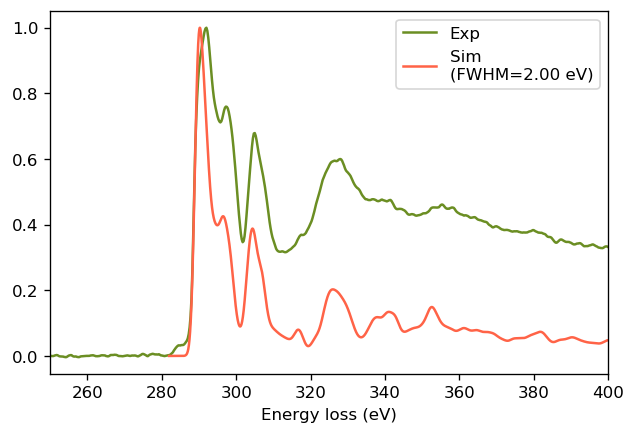

In [5]:

#%% blur reference spectrum
fwhm = 2
blur = Gaussian_blur(ref, fwhm)

# compare the blur_ref to experimental
plt.figure(dpi=120)
plt.plot(ex_s, sp.data+0, color=clabel['exp'], 
         label='Exp')
plt.plot(ex_r, blur.data, color=clabel['blur'], 
         label='Sim \n(FWHM=%.2f eV)'%fwhm)
plt.xlim([250,400])
plt.legend()
plt.xlabel('Energy loss (eV)')

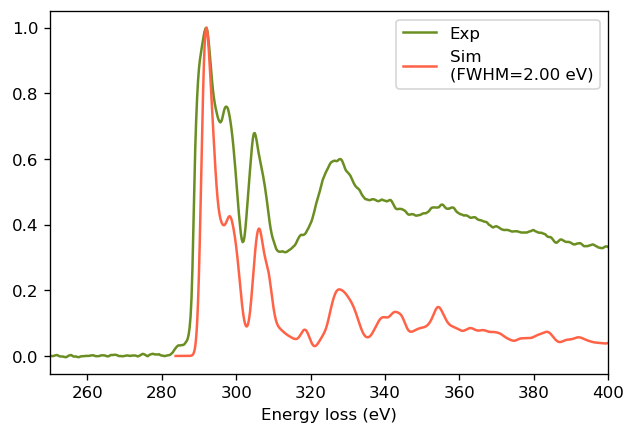

In [6]:
#%% shift spectrum by the max
max_ind_r = np.argmax(blur.data)
max_ind_s = np.argmax(sp.data)

de = ex_s[max_ind_s] - ex_r[max_ind_r]

blur.axes_manager['Energy loss'].offset = \
    blur.axes_manager['Energy loss'].offset + de
ex_r = blur.axes_manager['Energy loss'].axis

plt.figure(dpi=120)
plt.plot(ex_s, sp.data+0, color=clabel['exp'], 
         label='Exp')
plt.plot(ex_r, blur.data, color=clabel['blur'], 
         label='Sim \n(FWHM=%.2f eV)'%fwhm)
plt.xlim([250,400])
plt.legend()
plt.xlabel('Energy loss (eV)')
plt.show()


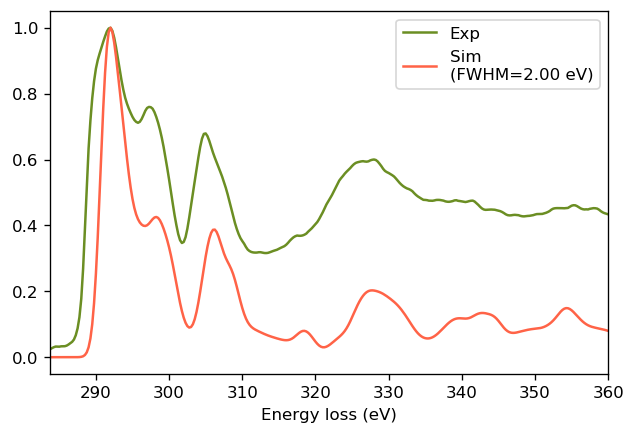

In [7]:
#%% Equalize the step
def Equal_Step(src, ref):
    # src: source spectrum image (hyperspy object)
    # ref: reference spectrum image (hyperspy object)
    # return src2 and ref2, which are have the same E-axis
    
    # deal with the E-axis
    ex_s = src.axes_manager['Energy loss'].axis
    ex_r = ref.axes_manager['Energy loss'].axis
    
    new_scale = max(src.axes_manager['Energy loss'].scale,
                    ref.axes_manager['Energy loss'].scale)
    
    new_range = [max(ex_r[0], ex_s[0]), min(ex_r[-1], ex_s[-1])]
    new_range[0]=np.ceil(new_range[0]/new_scale) * new_scale
    new_range[1]=np.floor(new_range[1]/new_scale) * new_scale
    ex_new = np.arange(new_range[0], new_range[1], new_scale)
    
    # experimental data
    src2 = src.deepcopy()
    src2.axes_manager['Energy loss'].size = len(ex_new)
    src2.axes_manager['Energy loss'].offset = ex_new[0]
    src2.axes_manager['Energy loss'].scale = new_scale
    fs = interpolate.interp1d(ex_s, src.data, kind='cubic')
    src2.data = fs(ex_new)

    # reference data
    ref2 = ref.deepcopy()
    ref2.axes_manager['Energy loss'].size = len(ex_new)
    ref2.axes_manager['Energy loss'].offset = ex_new[0]
    ref2.axes_manager['Energy loss'].scale = new_scale
    fr = interpolate.interp1d(ex_r, ref.data, kind='cubic')
    ref2.data = fr(ex_new)
    
    return src2, ref2

sp2, blur2 = Equal_Step(sp, blur)
ex_new = sp2.axes_manager['Energy loss'].axis
plt.figure(dpi=120)
plt.plot(ex_new, sp2.data, color=clabel['exp'], 
         label='Exp')
plt.plot(ex_new, blur2.data, color=clabel['blur'], 
         label='Sim \n(FWHM=%.2f eV)'%fwhm)
plt.xlim([ex_new[0], 360])
plt.legend()
plt.xlabel('Energy loss (eV)')
plt.show()

Similarity = 3.021


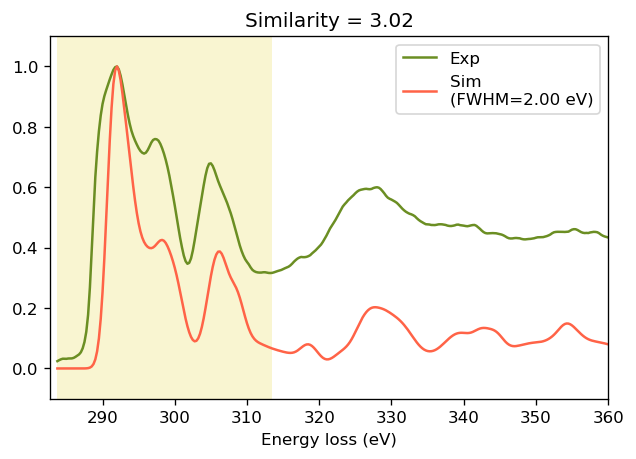

In [8]:
#%% calculate the similarity
w=30
def similarity(si1, si2, w=w):
    # w: window, unit: eV
    ex = si1.axes_manager['Energy loss'].axis
    ind = ex < (ex[0]+w)
    s = si1.data[ind] - si2.data[ind]
    s = np.sqrt(np.sum(s**2))
    return s

s = similarity(sp2, blur2)
print('Similarity = %.3f'%s)
with open('similarity.txt', 'w') as f:
    f.write('%.2f'%s)

ind = ex_new < (ex_new[0]+w)
plt.figure(dpi=120)
plt.fill_between(ex_new[ind], np.ones(len(ex_new[ind]))*1.5, 
                 np.ones(len(ex_new[ind]))*-0.2,
                 color='khaki', alpha=0.4, lw=0)
plt.plot(ex_new, sp2.data, color=clabel['exp'], 
         label='Exp')
plt.plot(ex_new, blur2.data, color=clabel['blur'], 
         label='Sim \n(FWHM=%.2f eV)'%fwhm)

plt.ylim([-0.1,1.1])
plt.xlim([ex_new[0]-1, 360])
plt.legend()
plt.xlabel('Energy loss (eV)')
plt.title('Similarity = %.2f'%s)
plt.show()
